In [1]:
import arviz as az
import arviz_plots as azp
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.special as jss
import marimo as mo
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns

azp.style.use("arviz-vibrant")

/Users/curro/Documents/Dev/handbook-abc-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Empirical likelihoods NUTS

## References

[Approximating the Likelihood in Approximate Bayesian Computation](https://arxiv.org/pdf/1803.06645)


Empirical likelihoods can be used to do approximate statistical inference without making strong parametric assumptions about the data generating process. Rather than assuming that a certain distribution (e.g., normal, Poisson) generated the data, we can specify moment conditions that the data should satisfy (e.g., mean) and use empirical likelihoods to perform inference based on these moments.

This idea was introduced in the late 1980s. The appealing thing is that the empirical likelihood shares some assymptotic properties with the actual likelihood. However, it's not widely used (I think), I wonder why. In this notebook I use the log-adjusted empirical likelihood following the R implementation in https://github.com/jlimrasc/VBel. Optimization is done with an efficient algorithm (solving the Lagrangian dual problem) and it is JIT compiled using JAX which means that hopefully is not too slow and we can take advantage of automatic differentiation.

Below, some details about the implementatin:

### Adjusted empirical likelihood implementation

Evaluates the Log-Adjusted Empirical Likelihood (AEL) (Chen, Variyath, and Abraham 2008) for a given data set, moment conditions and parameter values.
The AEL function is formulated as

$$
\log \text{AEL}(\boldsymbol{\theta}) = \max_{\mathbf{w}'} \sum\limits_{i=1}^{n+1} \log(w_i'),
$$

where $\mathbf{z}_{n+1}$ is a pseudo-observation that satisfies

$$
h(\mathbf{z}_{n+1}, \boldsymbol{\theta}) = -\frac{a_n}{n} \sum\limits_{i=1}^n h(\mathbf{z}_i, \boldsymbol{\theta})
$$

for some constant $a_n > 0$ that may (but not necessarily) depend on $n$, and $\mathbf{w}' = (w_1', \ldots, w_n', w_{n+1}')$ is a vector of probability weights that define a discrete distribution on $\{\mathbf{z}_1, \ldots, \mathbf{z}_n, \mathbf{z}_{n+1}\}$, and are subject to the constraints

$$
\sum\limits_{i=1}^{n+1} w_i' h(\mathbf{z}_i, \boldsymbol{\theta}) = 0, \quad \text{and} \quad \sum\limits_{i=1}^{n+1} w_i' = 1.
$$

Here, the maximizer $\tilde{\mathbf{w}}$ is of the form

$$
\tilde{w}_i = \frac{1}{n+1} \frac{1}{1 + \lambda_{\text{AEL}}^\top h(\mathbf{z}_i, \boldsymbol{\theta})},
$$

where $\lambda_{\text{AEL}}$ satisfies the constraints

$$
\frac{1}{n+1} \sum\limits_{i=1}^{n+1} \frac{h(\mathbf{z}_i, \boldsymbol{\theta})}{1 + \lambda_{\text{AEL}}^\top h(\mathbf{z}_i, \boldsymbol{\theta})} = 0, \quad \text{and} \quad
\frac{1}{n+1} \sum\limits_{i=1}^{n+1} \frac{1}{1 + \lambda_{\text{AEL}}^\top h(\mathbf{z}_i, \boldsymbol{\theta})} = 1.
$$

In [2]:
@jax.jit
def _adjusted_empirical_loglikelihood(data, moments):
    # Moment condition
    data = data - moments
    # Empirical likelihoods have a different support than the "original" likelihoods
    # This is because some parameter combinations cannot satisfy the moment conditions
    # and therefore have zero empirical likelihood. This makes optimization difficult.
    # To alleviate this problem, we add a pseudo-observation to the data set. If
    # a is small (in the orden of log(n)), we still get a good (assymptotic) approximation
    # but the support of the empirical likelihood is extended to the whole parameter space.
    # Pseudo-observation
    n1 = data.shape[0]
    a = 0.5 * jnp.log(n1)
    pseudo_observation = -a / n1 * moments.sum()
    pseudo_col = jnp.atleast_2d(pseudo_observation)
    # Add pseudo-observation to data
    data_col = jnp.atleast_2d(data).reshape(-1, 1)
    h_array = jnp.concatenate([data_col, pseudo_col]).reshape((-1, 1))
    # Compute lambda using modified Newton-Raphson
    n = h_array.shape[0]
    d = h_array.shape[1]

    def newton_step(lam_prev, _):
        # Original Rccp code in comments for reference
        # wi = 1 / (1 + lam^T h_i)
        # wi = pow((1 + lam_prev.transpose() * h_list[i]),-1);
        h_lam = (h_array @ lam_prev).ravel()
        wi_arr = 1.0 / (1.0 + h_lam)
        assert wi_arr.shape == (n,)
        # Condition 1
        # if (pow(wi,-1) >= 1.0/(double)n)
        threshold = 1.0 / n
        condition = (1.0 / wi_arr) >= threshold
        # vi and vi2 computation
        vi = jnp.where(condition, wi_arr, 2 * n - (n**2) / wi_arr)
        v2 = jnp.where(condition, wi_arr, n)
        # dF += vi * h_list[i];
        dF = jnp.sum(vi.reshape(-1, 1) * h_array, axis=0)
        assert dF.shape == (d,)
        # D_arr[i] = pow(vi2,2);
        D_arr = v2**2
        assert D_arr.shape == (n,)
        # D = D_arr.asDiagonal();
        # // Calculate P (i.e. d2F)
        # P = -H_Zth.transpose() * D * H_Zth;
        # P = - h_array.T @ jnp.diag(D_arr) @ h_array
        # Perhaps it's more efficient to use einsum??
        P = -jnp.einsum("ni,n,nj->ij", h_array, D_arr, h_array)
        assert P.shape == (d, d)
        # lam_prev = lam_prev - P.inverse() * dF;
        lam_new = lam_prev - jnp.linalg.solve(P, dF)
        # Carry, output
        return lam_new, None

    lam0 = jnp.zeros((d,))
    num_steps = 50
    lam_final, _ = jax.lax.scan(newton_step, lam0, None, length=num_steps)
    # AEL calculation
    # for (int i = 0; i < n; i++) {
    #    accum += log(1.0 + (lambda.transpose() * h_list[i])[0]); // Get double vs mat hence [0]
    # }
    accum = jnp.sum(jnp.log(1.0 + jnp.dot(h_array, lam_final)))
    # Numerically more stable using log1p?
    accum = jnp.sum(jnp.log1p((h_array @ lam_final).ravel()))
    # accum = jnp.sum(jnp.log1p(h_array @ lam_final))
    # log_AEL = -(accum + n * log(n));
    log_AEL = -(accum + n * jnp.log(n))
    return log_AEL


@jax.jit
def adjusted_empirical_loglikelihood(dataset, moments):
    fun = lambda theta: _adjusted_empirical_loglikelihood(
        dataset, theta.reshape((1, -1))
    )
    # return jnp.nan_to_num(jax.vmap(fun)(moments), nan=-jnp.inf)
    return jax.vmap(fun)(moments)

## Example

Suppose the model is specified as $y_1, \dots, y_{50} \sim \text{Poisson}(\theta)$, with uniform prior $\theta \sim U(0, 10)$.

In [3]:
theta_true = 2.5
observed_y = dist.Poisson(theta_true).sample(jr.key(1), (50,)).astype(jnp.float32)
observed_y

Array([4., 2., 1., 1., 3., 2., 1., 0., 5., 2., 2., 6., 5., 3., 2., 3., 2.,
       5., 5., 0., 5., 3., 2., 2., 2., 4., 2., 3., 2., 3., 0., 7., 1., 2.,
       4., 1., 6., 1., 2., 4., 3., 3., 2., 2., 3., 2., 4., 2., 4., 3.],      dtype=float32)

#### Empirical likelihood versus true likelihood

In [4]:
obs_moments = jnp.array([observed_y.mean()])

<Axes: xlabel='$\\theta$', ylabel='$\\frac{d}{d\\theta} \\log p(\\theta | y)$'>

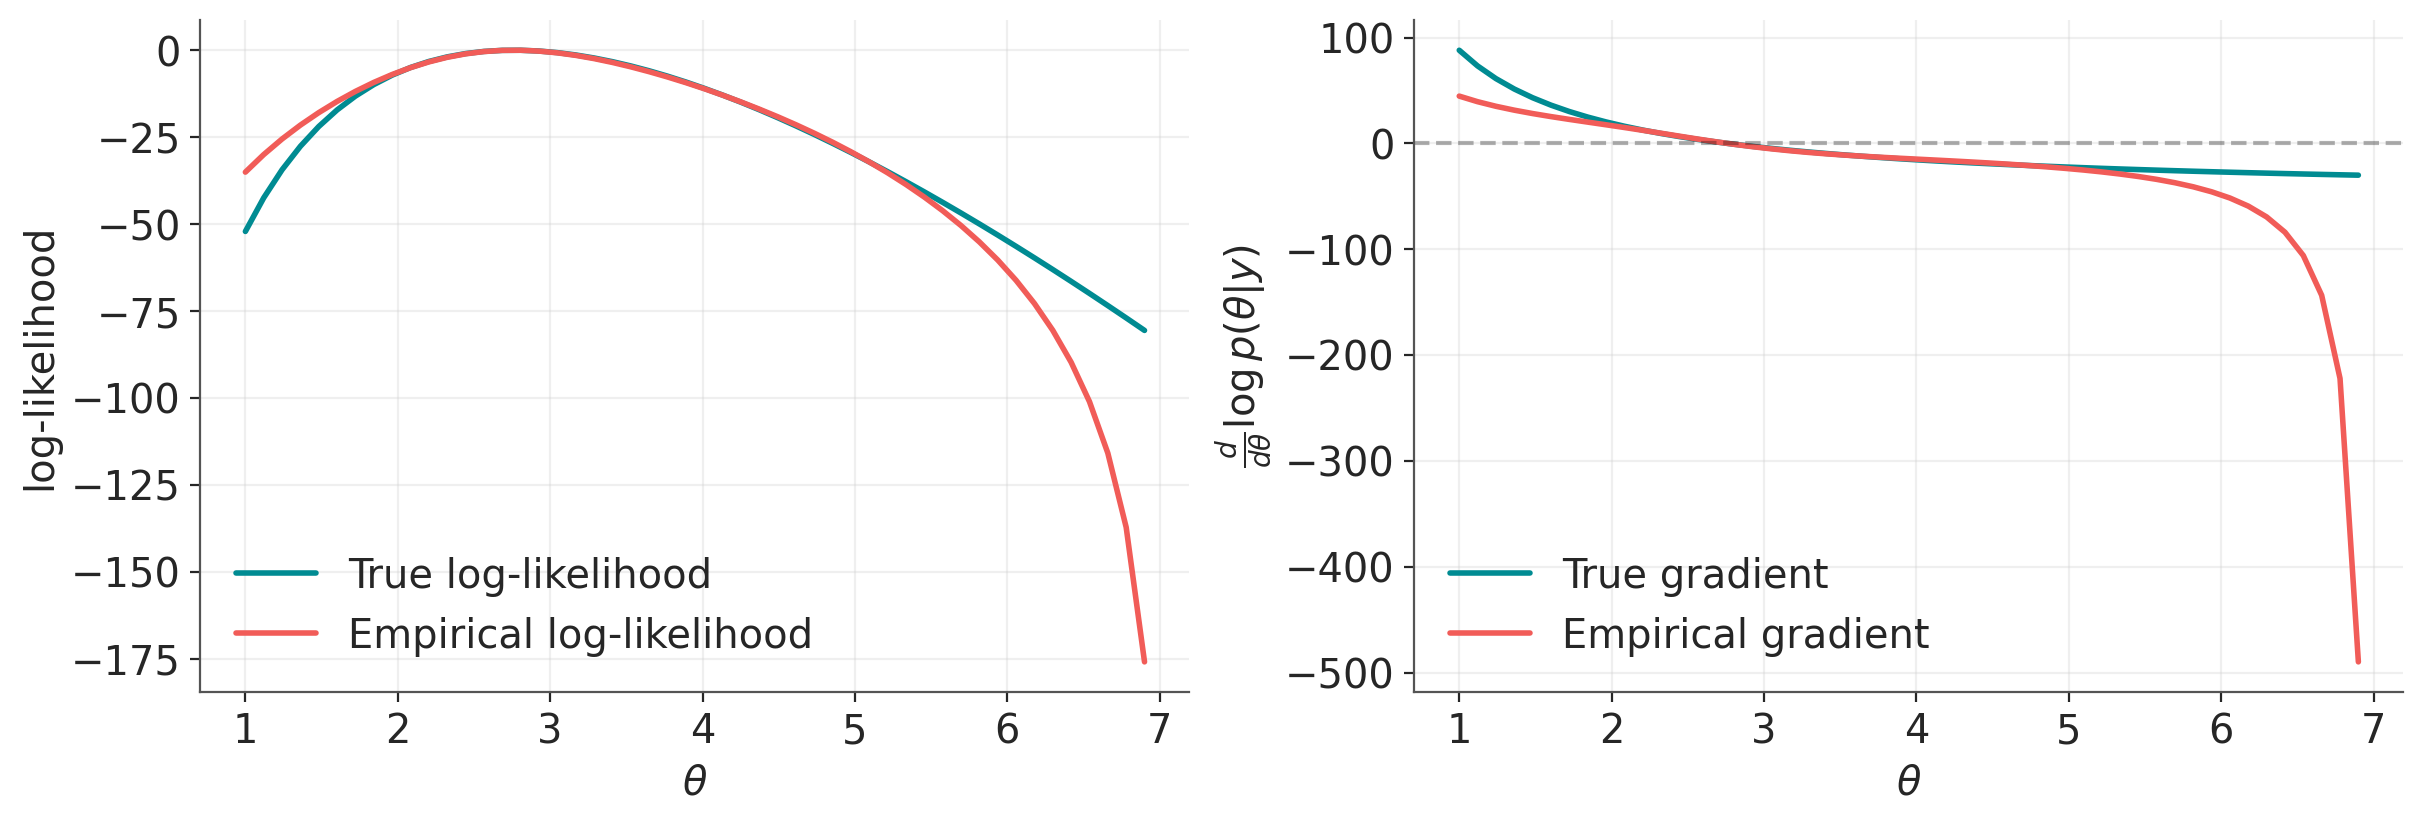

In [5]:
# Define function to compute empirical likelihood for a single theta value
def em_loglik_single(theta_val):
    return adjusted_empirical_loglikelihood(observed_y, jnp.array([theta_val])).sum()


# Compute gradients using JAX autodiff
grad_em_loglik = jax.grad(em_loglik_single)

# Evaluate gradients on grid
_grid = np.linspace(1, 6.9, 50)
_em_grads = np.array([float(grad_em_loglik(jnp.array(theta))) for theta in _grid])


# True likelihood gradient for comparison
def true_loglik_single(theta_val):
    return dist.Poisson(theta_val).log_prob(observed_y).sum()


grad_true_loglik = jax.grad(true_loglik_single)
_true_grads = np.array([float(grad_true_loglik(jnp.array(theta))) for theta in _grid])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot log-likelihoods
_liks = jax.vmap(dist.Poisson(_grid).log_prob)(observed_y).sum(axis=0)
_liks = _liks - _liks.max()
_em_liks = jax.vmap(
    lambda theta: adjusted_empirical_loglikelihood(observed_y, jnp.array([theta])).sum()
)(_grid)
_em_liks = _em_liks - _em_liks.max()

ax1.plot(_grid, _liks, label="True log-likelihood", linewidth=2)
ax1.plot(_grid, _em_liks, label="Empirical log-likelihood", linewidth=2)
ax1.set_xlabel(r"$\theta$")
ax1.set_ylabel("log-likelihood")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot gradients
ax2.plot(_grid, _true_grads, label="True gradient", linewidth=2)
ax2.plot(_grid, _em_grads, label="Empirical gradient", linewidth=2)
ax2.axhline(y=0, color="k", linestyle="--", alpha=0.3)
ax2.set_xlabel(r"$\theta$")
ax2.set_ylabel(r"$\frac{d}{d\theta} \log p(\theta | y)$")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.gca()

In [6]:
prior = dist.Uniform(0, 10, validate_args=True)


def prior_log_prob(params):
    theta = params["theta"]
    return prior.log_prob(theta)


def loglikelihood(params):
    theta = params["theta"]
    return adjusted_empirical_loglikelihood(observed_y, jnp.array([theta])).sum()


def logdensity(params):
    lprior = prior_log_prob(params)
    ll = jax.lax.cond(
        jnp.isfinite(lprior).squeeze(),
        lambda _: loglikelihood(params),
        lambda _: -jnp.inf,
        operand=lprior,
    )
    return jnp.squeeze(lprior + ll)

In [7]:
import blackjax


def empirical_likelihood_nuts(
    key, log_density, initial_positions, num_samples, num_warmups=1000
):
    """
    key: JAX random key
    log_density: log posterior density
    initial_positions: list of initial position dicts, one per chain
    num_samples : number of samples
    num_warmups: number of warmups iterations
    """

    def inference_loop(rng_key, kernel, initial_state, num_samples):
        @jax.jit
        def one_step(state, rng_key):
            state, _ = kernel(rng_key, state)
            # Extract theta from position dict
            theta = state.position["theta"]
            return state, theta

        keys = jax.random.split(rng_key, num_samples)
        _, theta_samples = jax.lax.scan(one_step, initial_state, keys)

        return theta_samples

    def _run_chain(args):
        init_pos, chain_key = args
        warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
        warmup_key, sample_key = jax.random.split(chain_key, 2)
        (state, parameters), _ = warmup.run(warmup_key, init_pos, num_steps=num_warmups)
        kernel = blackjax.nuts(logdensity, **parameters).step
        return inference_loop(sample_key, kernel, state, num_samples)

    num_chains = len(initial_positions)
    chain_keys = jax.random.split(key, num_chains)

    # Stack initial positions
    stacked_init = jax.tree.map(
        lambda *arrays: jnp.stack(arrays, axis=0), *initial_positions
    )

    # Run chains sequentially
    all_theta_samples = []
    for i in range(num_chains):
        init_pos = {k: v[i] for k, v in stacked_init.items()}
        theta_samples = _run_chain((init_pos, chain_keys[i]))
        all_theta_samples.append(theta_samples)

    # Stack across chains: shape (num_chains, num_samples, param_dim)
    all_theta = jnp.stack(all_theta_samples, axis=0)
    posterior_dict = {"theta": np.asarray(all_theta)}
    return az.from_dict(posterior=posterior_dict)

In [8]:
initial_positions = [
    {"theta": jnp.array([1.0])},
    {"theta": jnp.array([2.0])},
    {"theta": jnp.array([3.0])},
    {"theta": jnp.array([4.0])},
]
nuts_key = jr.key(0)

In [9]:
idata = empirical_likelihood_nuts(
    nuts_key, logdensity, initial_positions, 2000, num_warmups=2000
)

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],2.781,0.229,2.362,3.208,0.004,0.003,2873.0,3553.0,1.0


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

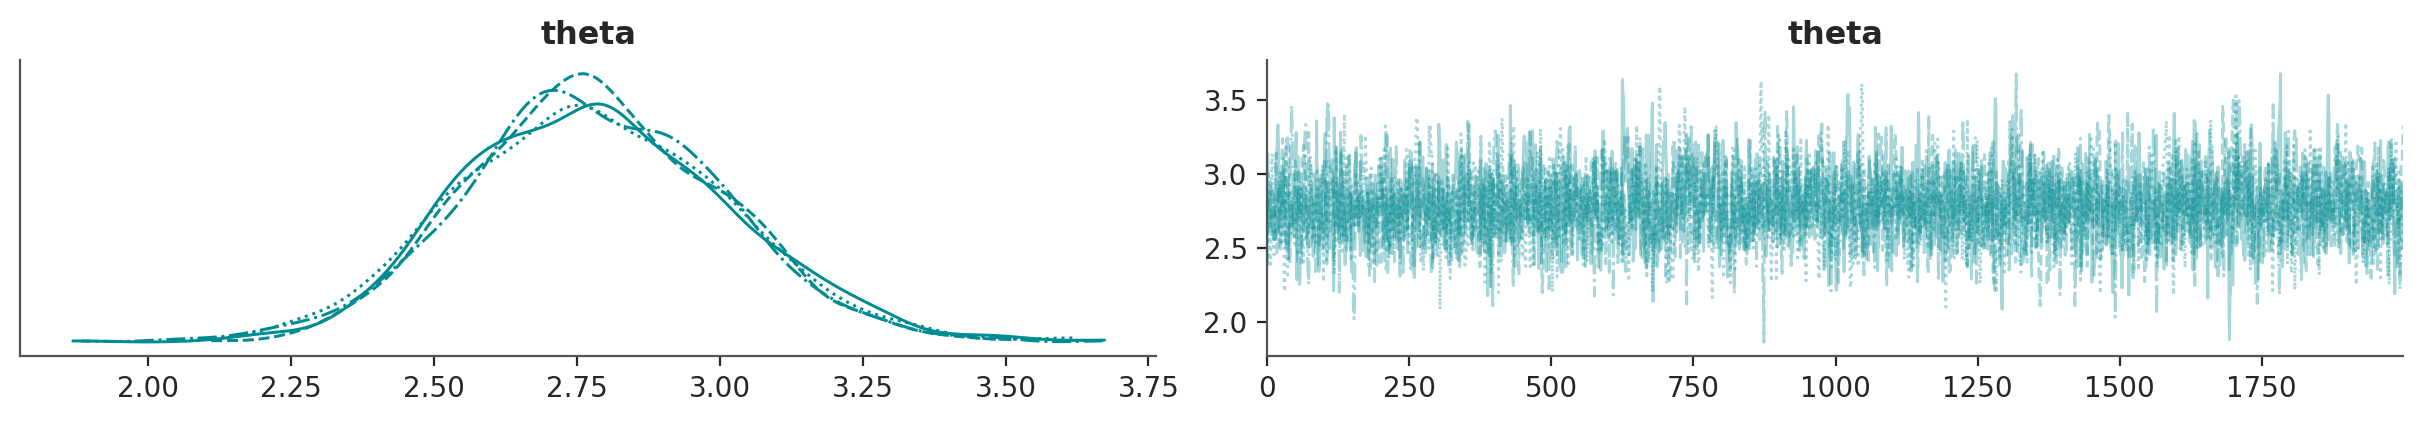

In [11]:
az.plot_trace(idata)